In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spiking_radio_reservoir import setup_schliebs_connectivity
from scipy.sparse.linalg import eigs

# Reservoir model (Schliebs)

The reservoir model implemented constists of $f N$ inhibitory and $(1-f)N$ excitatory neurons positioned on a 3-dimensional lattice of size $(N_{g_x}, N_{g_y}, N_{g_z})$, such that $N = N_{g_x}\cdot N_{g_y}\cdot N_{g_z}$ and where $f\in(0, 1)$ describes the fraction of inhibitory neurons.

The connection probability between neurons is distance dependent in order to (possibly) obtain a small-world type of connectivity (high clustering coefficient and small average shortest path length). The connection probability amplitude also depends on the type of the neurons involved. For a pair of neurons $A$ and $B$ of type $t_A$ and $t_B$ with coordinates $x_A$ and $x_B$, the probability of connection is given by

$$
p(x_A, x_B, t_A, t_B; \lambda) = \Gamma(t_A, t_B)\exp\left(-\frac{d(x_A, x_B)^2}{\lambda^2}\right),
$$

where $d(x_A, x_B)$ is the Euclidean distance on the lattice between the neurons, $\lambda$ describes the connection density and 

$$
\Gamma(t_A, t_B)=
\begin{cases}
0.3, t_A=\text{ex}~\text{and}~t_B=\text{ex} \\
0.2, t_A=\text{ex}~\text{and}~t_B=\text{inh} \\
0.5, t_A=\text{inh}~\text{and}~t_B=\text{ex} \\
0.1, t_A=\text{inh}~\text{and}~t_B=\text{inh}
\end{cases}
$$

(source: Reservoir-Based Evolving SNN for Spatio-temporal Pattern Recognition, 2011).

The excitatory and inhibitory weights of the connections are randomly drawn from two separate distributions: $\cal{N}(\mu_E, \sigma_E)$ and $\cal{N}(\mu_I, \sigma_I)$. We ensure that excitatory weights are positive and inhibitory weights are negative (by multplying the randomly drawn number with -1 in the inhibitory case and discarding incompatible choices).

## Model parameter summary

| parameter           | description                                              | value |
|---------------------|----------------------------------------------------------|-------|
| $N$                 | number of reservoir neurons                              | 200   |
| $N_{g_x}$           | lattice dimension in x-axis                              | 5     |
| $N_{g_y}$           | lattice dimension in y-axis                              | 5     |
| $N_{g_z}$           | lattice dimension in z-axis                              | 8     |
| $f$                 | fraction of inhibitory neurons                           | 0.2   |
| $\Gamma(ex, ex)$    | probability amplitube for ex-ex connections              | 0.3   |
| $\Gamma(ex, inh)$   | probability amplitube for ex-inh connections             | 0.2   |
| $\Gamma(inh, ex)$   | probability amplitube for inh-ex connections             | 0.5   |
| $\Gamma(inh, inh)$  | probability amplitube for inh-inh connections            | 0.1   |
| $\lambda$           | connection density                                       | 2     |
| $\mu_E$             | mean value of the excitatory weight distribution         | 1000  |
| $\sigma_E$          | standard deviation of the excitatory weight distribution | 100   |
| $\mu_I$             | mean value of the inhibitory weight distribution         | 1000  |
| $\sigma_I$          | standard deviation of the inhibitory weight distribution | 100   |

In [2]:
pIR = 0.3
N = 200
Ngx = 5
Ngy = 5
Ngz = 8
f = 0.2
AoC = [0.3, 0.2, 0.5, 0.1]
DoC = 0.2
loc_wResE = 1
scale_wResE = 0.5
loc_wResI = -1
scale_wResI = 0.5

In [3]:
connectivity = setup_schliebs_connectivity(N, f, pIR, Ngx, Ngy, Ngz, AoC, DoC, loc_wResE, scale_wResE, loc_wResI, scale_wResI, rebalance=False)

# Input balance

We study the input balance for all neurons in the reservoir. Given a weight matrix $W=(w_{ij})_{i,j=1}^N$, the input balance stability condition states that

$$
\sum_{j} w_{ij} = 0,~ \forall i.
$$

Therefore, if all neurons are equally active, excitation and inhibition cancel each other on a neuron-by-neuron level ([source](https://neuronaldynamics.epfl.ch/online/Ch20.S1.html)).

In [4]:
Wres = np.zeros((N, N))
Wres[connectivity['res_res']['i'], connectivity['res_res']['j']] = connectivity['res_res']['w']

Text(0, 0.5, 'target neuron')

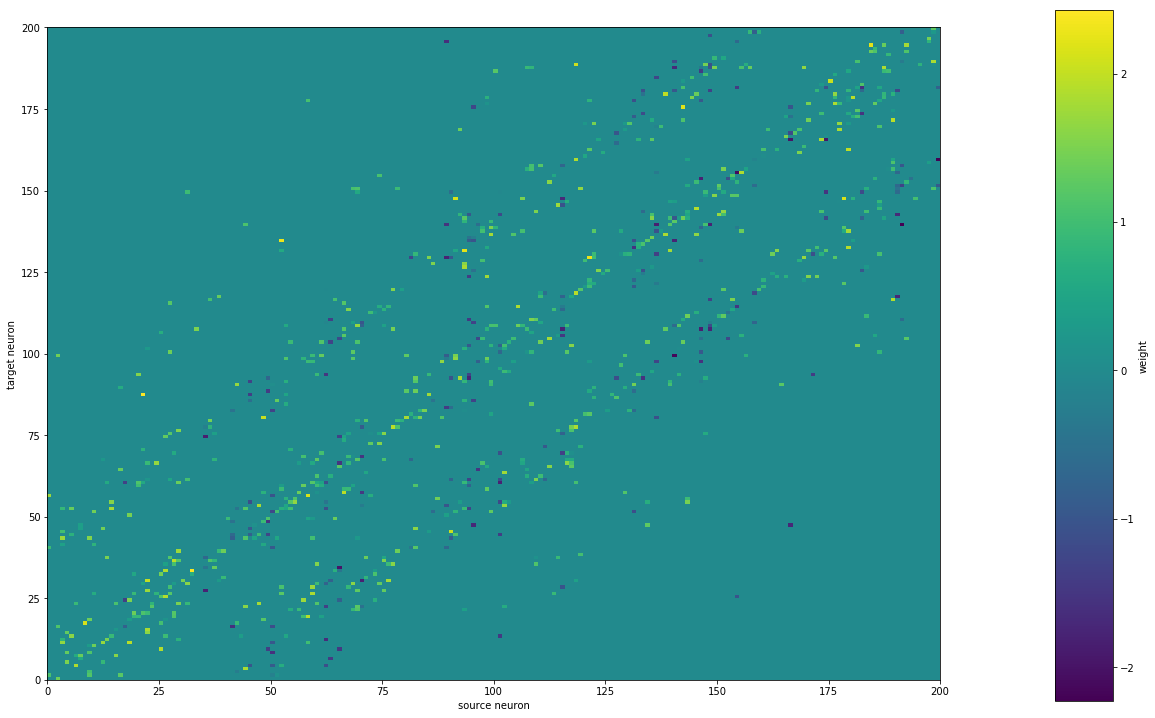

In [5]:
fig, ax = plt.subplots(figsize=(16, 12))
im = ax.imshow(Wres.T, interpolation='nearest', origin='low', aspect='auto', \
                extent=[0, N, 0, N], cmap='viridis', vmin=Wres.min(), vmax=Wres.max())
ax_cbar1 = fig.add_axes([1, 0.1, 0.05, 0.8])
plt.colorbar(im, cax=ax_cbar1, orientation='vertical', label='weight')
ax.set_xlabel("source neuron")
ax.set_ylabel("target neuron")

In [6]:
input_balance = [Wres[:, i].sum() for i in range(N)]
mean_ib = np.mean(input_balance)
sigma_ib = np.std(input_balance)
neurons = np.arange(N)

In [7]:
Wres_ex = [Wres[np.where(Wres[:, i]>0)[0], i].sum() for i in range(N)]
Wres_inh = [Wres[np.where(Wres[:, i]<0)[0], i].sum() for i in range(N)]

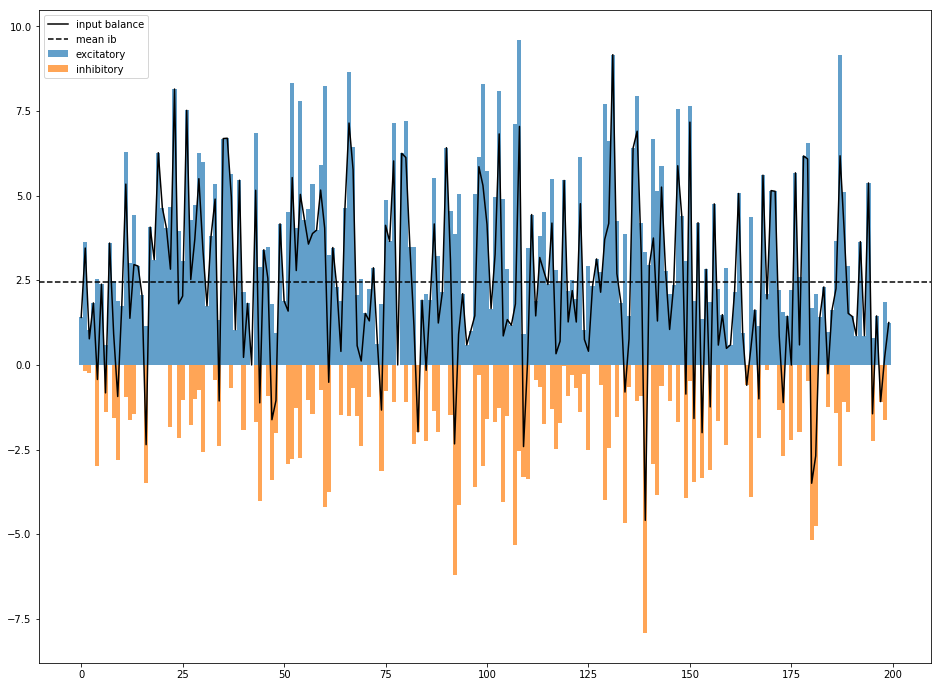

In [8]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.bar(neurons, Wres_ex, width=1, alpha=0.7, label="excitatory")
ax.bar(neurons, Wres_inh, width=1, alpha=0.7, label="inhibitory")
ax.plot(neurons, input_balance, c="k", label="input balance")
ax.axhline(mean_ib, color="k", linestyle="dashed", label="mean ib")
ax.legend(loc="best")

The default parameters do not satisfy the input balance condition. **How can this condition be reached programmatically without involving inhibitory plasticity?**

Since the weight matrix contains excitatory (positive) and inhibitory (negative) weights we can rewrite it as follows

$$
W_{res} = W_{res_E} + W_{res_I}.
$$

The input balance condition requires that $\sum_{j}W_{res_{ij}} = 0$ for all rows $i$. For an initial random weight matrix that does not satisfy this condition we can write

$$
\sum_{j\in E_{i}} W_{res_{ij}} + \sum_{k\in I_{i}} W_{res_{ik}} + \sum_{l}\Delta_{il} = 0
$$

where $E_i$ and $I_i$ are the indices of the excitatory and inhibitory weights of the i-th row, while $\Delta_{il}$ represents the corrections to the weights of the i-th row necessary to reach input balance. These corrections can also be splitted into two sets of contributions to excitatory and inhibitory weights respectively

$$
\sum_{l}\Delta_{il} = \sum_{j\in E_{i}}\Delta_{ij} + \sum_{k\in I_{i}}\Delta_{ik}.
$$

The full expression is thus

$$
\sum_{j\in E_{i}} \left(W_{res_{ij}} + \Delta_{ij}\right) + \sum_{k\in I_{i}} \left(W_{res_{ik}} + \Delta_{ik}\right) = 0.
$$

Assuming small corrections $\Delta_{ij} \ll W_{res_{ij}}$ for $j\in E_{i}$, we can re-arrange the equation above to find an expression for the corrections to the inhibitory weights as

$$
\sum_{k\in I_{i}} \Delta_{ik} \approx -\sum_{j\in E_{i}} W_{res_{ij}} -\sum_{k\in I_{i}} W_{res_{ik}}.
$$

The left hand side of the equation above is the total sum of the corrections that need to be applied to the inhibitory weights in order to achieve input balance for the i-th row. This global correction needs to be partitioned into smaller adjustments to individual weights, which can be done in multiple different ways. Since we do not make any particular assumptions on the importance of any specific connection weight, we treat all of them equally and distribute the global correction equally among the weights

$$
\Delta_{ih} = \frac{1}{|I_{i}|} \sum_{k\in I_{i}} \Delta_{ik},~\text{for}~h\in I_{i}.
$$

These steps are repeated in the same way for the excitatory weights, assuiming small corrections $\Delta_{ik} \ll W_{res_{ik}}$ for $k\in I_{i}$.

In [9]:
epsilon = 1e-3 # makes sure that no pre-existing connection is accidentally deleted

In [10]:
Wres_new = np.array(Wres)
for i in range(N):
    I = np.where(Wres_new[:, i]<0)[0]
    if len(I)>0:
        delta = -np.sum(Wres_new[:,i])/len(I)
        Wres_new[I, i] += delta+epsilon
    E = np.where(Wres_new[:, i]>0)[0]
    if len(E)>0:
        delta = -np.sum(Wres_new[:,i])/len(E)
        Wres_new[E, i] += delta+epsilon 

In [11]:
print(len(Wres_new.nonzero()[0]), len(Wres.nonzero()[0]))

940 940


In [12]:
input_balance = [Wres_new[:, i].sum() for i in range(N)]
mean_ib = np.mean(input_balance)
sigma_ib = np.std(input_balance)

In [13]:
Wres_ex = [Wres_new[np.where(Wres_new[:, i]>0)[0], i].sum() for i in range(N)]
Wres_inh = [Wres_new[np.where(Wres_new[:, i]<0)[0], i].sum() for i in range(N)]

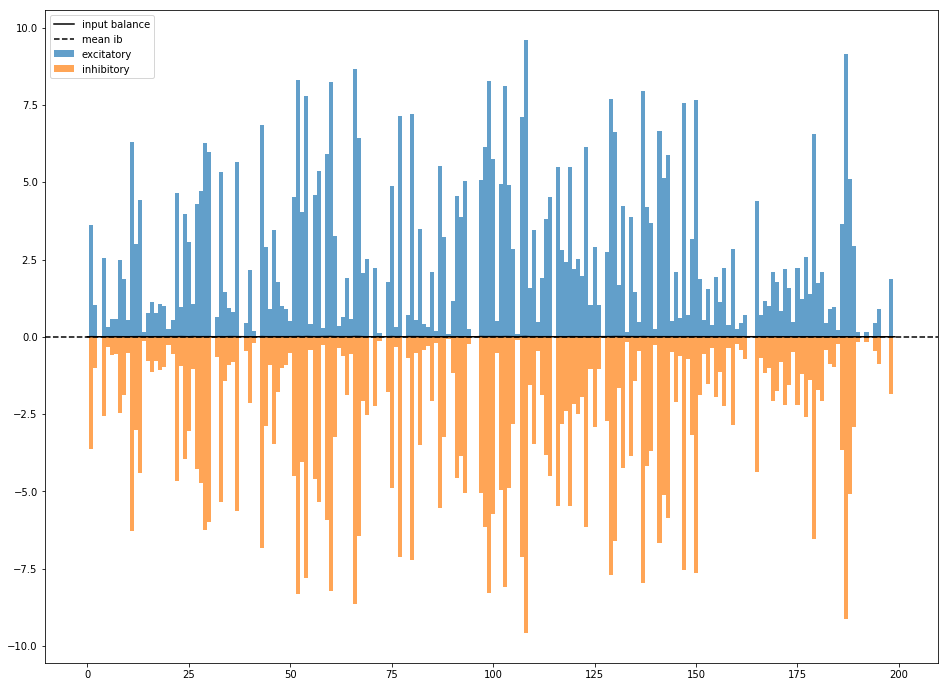

In [14]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.bar(neurons, Wres_ex, width=1, alpha=0.7, label="excitatory")
ax.bar(neurons, Wres_inh, width=1, alpha=0.7, label="inhibitory")
ax.plot(neurons, input_balance, c="k", label="input balance")
ax.axhline(mean_ib, color="k", linestyle="dashed", label="mean ib")
ax.legend(loc="best")

Text(0, 0.5, 'target neuron')

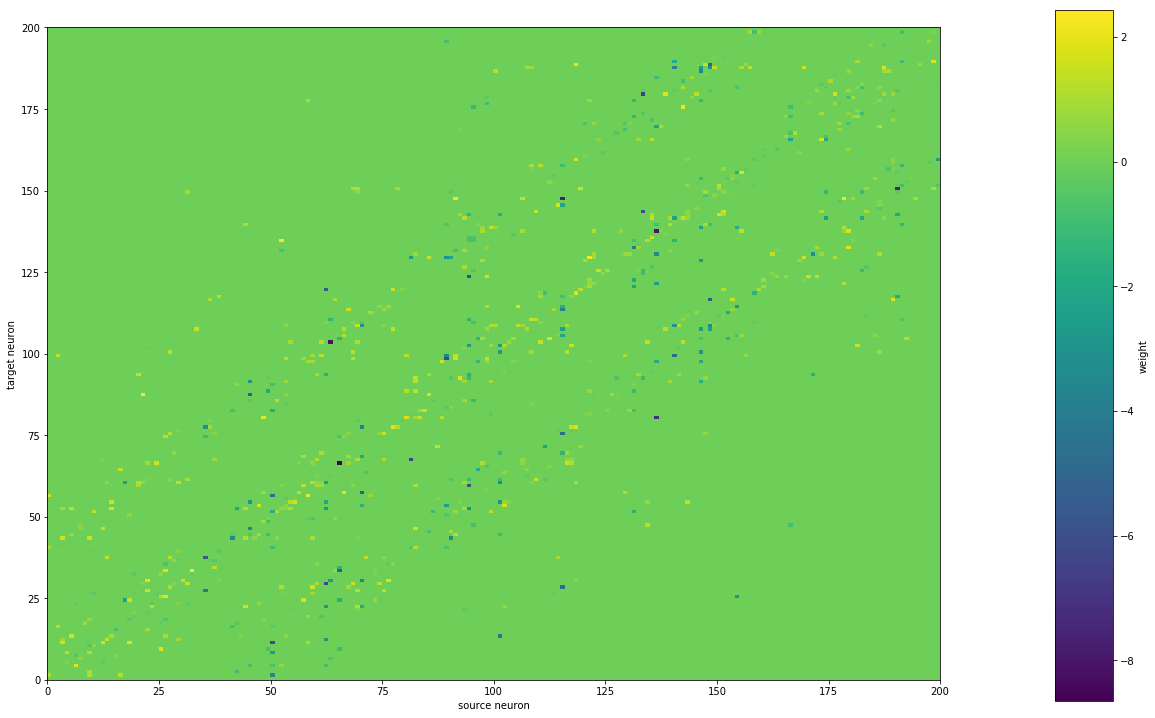

In [15]:
fig, ax = plt.subplots(figsize=(16, 12))
im = ax.imshow(Wres_new.T, interpolation='nearest', origin='low', aspect='auto', \
                extent=[0, N, 0, N], cmap='viridis', vmin=Wres_new.min(), vmax=Wres_new.max())
ax_cbar1 = fig.add_axes([1, 0.1, 0.05, 0.8])
plt.colorbar(im, cax=ax_cbar1, orientation='vertical', label='weight')
ax.set_xlabel("source neuron")
ax.set_ylabel("target neuron")

By splitting the input contribution between excitatory and inhibitory connections and adjusting only one group of weights at a time, we were able to change the weight matrix in order to satisfy the input balance for most neurons. Let's compare the initial weight distribution with the updated one:

Text(0.5, 0, 'weight')

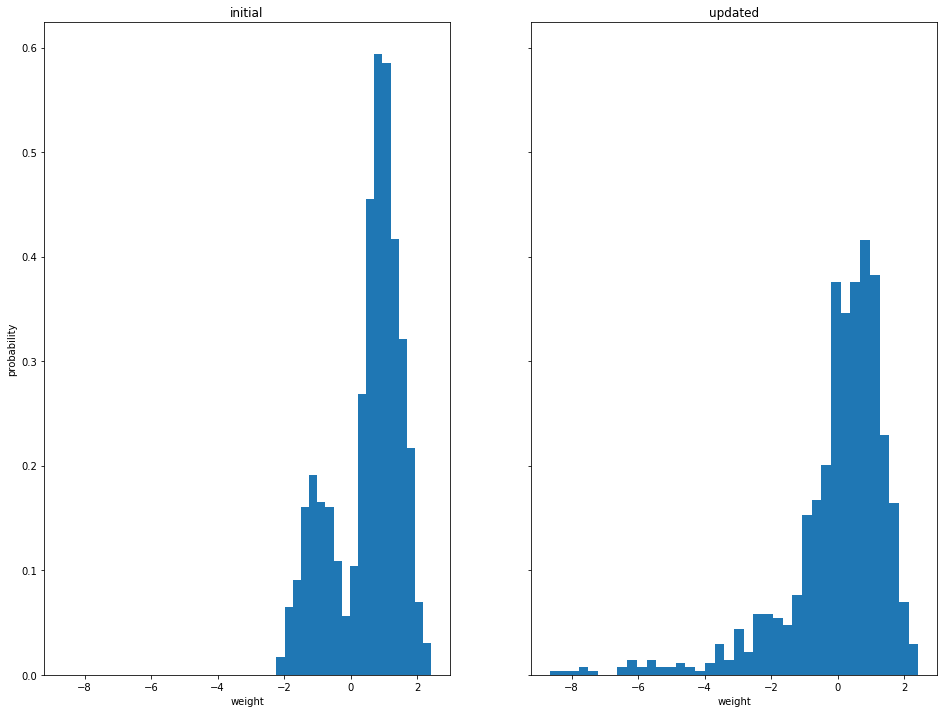

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 12))
ax1.hist(Wres[Wres.nonzero()], bins="auto", density=True, label="initial")
ax2.hist(Wres_new[Wres_new.nonzero()], bins="auto", density=True, label="updated")
ax1.set_title("initial")
ax1.set_xlabel("weight")
ax1.set_ylabel("probability")
ax2.set_title("updated")
ax2.set_xlabel("weight")

We can also plot the complex eigenvalues of the two weight matrices and compare them

In [17]:
ew, ev = eigs(Wres, k=N-2)
ew_new, ev_new = eigs(Wres_new, k=N-2)

In [18]:
centroid = [np.sum(ew.real)/len(ew.real), np.sum(ew.imag)/len(ew.imag)]
centroid_new = [np.sum(ew_new.real)/len(ew_new.real), np.sum(ew_new.imag)/len(ew_new.imag)]

Text(0.5, 0, '$Re(\\lambda)$')

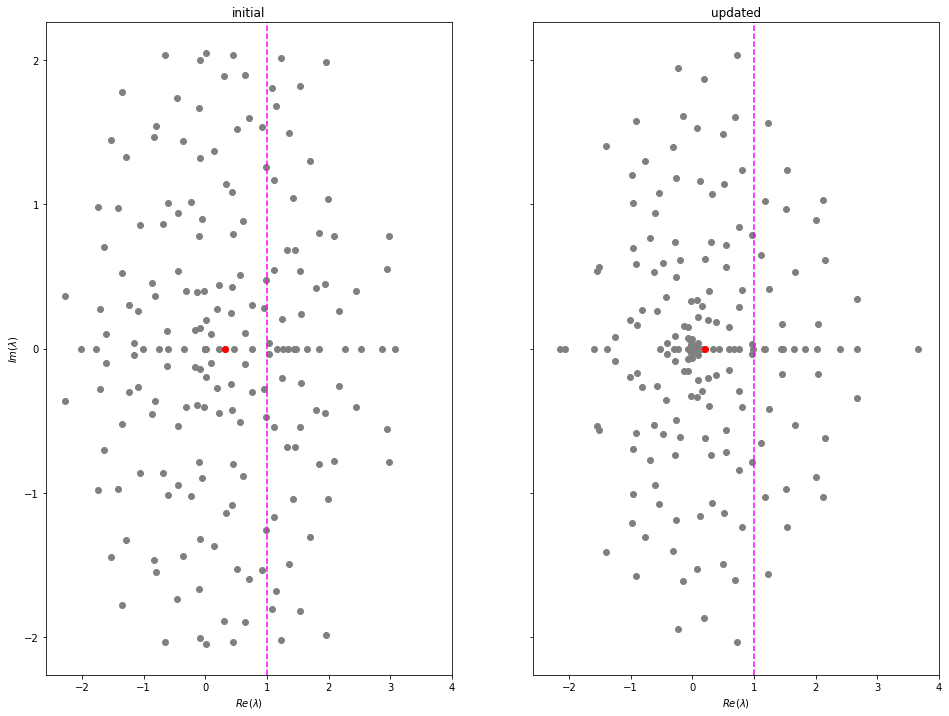

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 12))
ax1.scatter(ew.real, ew.imag, color="gray")
ax1.axvline(1.0, linestyle="dashed", color="magenta")
ax1.scatter(centroid[0], centroid[1], color="red")
#ax1.set_aspect('equal')
ax1.set_title("initial")
ax1.set_xlabel(r"$Re(\lambda)$")
ax1.set_ylabel(r"$Im(\lambda)$")
ax2.scatter(ew_new.real, ew_new.imag, color="gray")
ax2.axvline(1.0, linestyle="dashed", color="magenta")
ax2.scatter(centroid_new[0], centroid_new[1], color="red")
#ax2.set_aspect('equal')
ax2.set_title("updated")
ax2.set_xlabel(r"$Re(\lambda)$")